In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import re
import unicodedata
from openai import OpenAI

pd.set_option('display.max_columns', None)

# 1. Lecture des taux de la BCE et plot

In [2]:
data_rates = pd.read_csv(

    'data/ecb_rates.csv',
    index_col=0,
    header=0,
    names=[
        'Date',
        'Time_Period',
        'Deposit_Change',
        'Deposit_Level',
        'Lending_Change',
        'Lending_Level',
        'Refinancing_Change',
        'Fixed_Rate_Level',
        'Variable_Rate_Level',
        'Deposit_Level_Alt',
        'Fixed_Rate_Level_Alt',
        'Min_Bid_Rate_Level'
    ],
    
    parse_dates=True,

    ).drop(columns='Time_Period')


<Axes: xlabel='Date'>

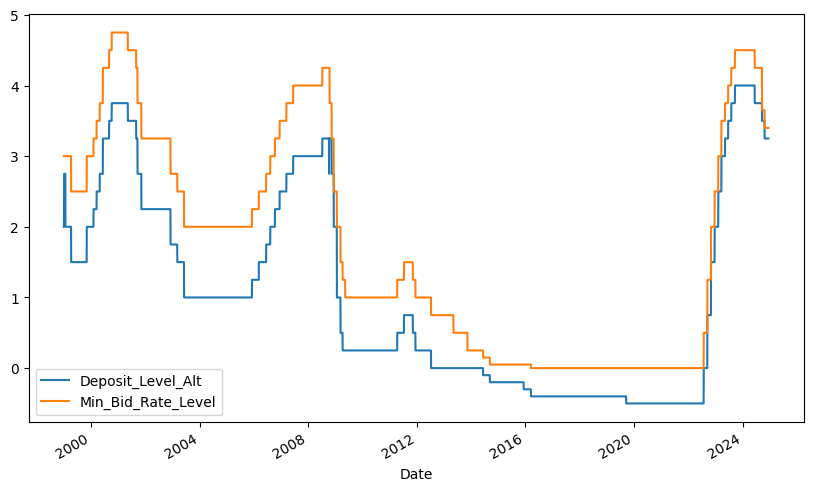

In [3]:
data_rates[['Deposit_Level_Alt', 'Min_Bid_Rate_Level']].plot(figsize=(10,6))

### Affichons les dates ou les changements ont été positifs/négatifs

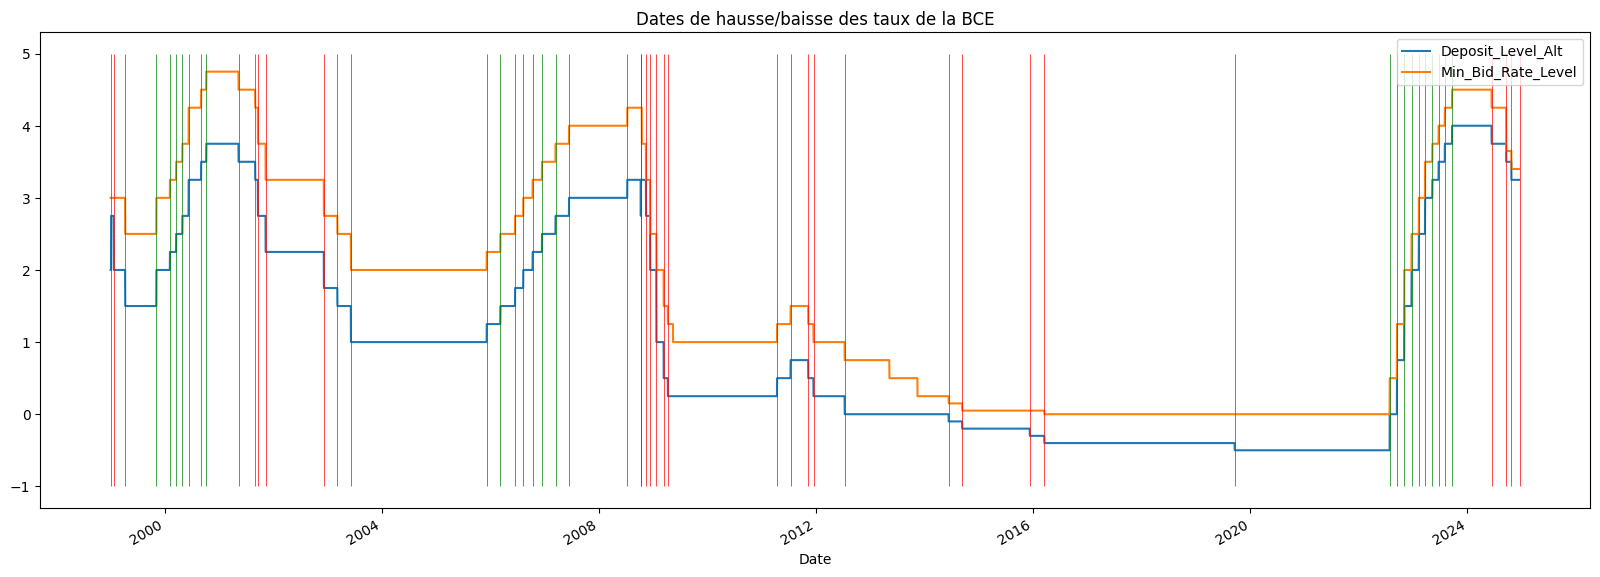

In [4]:
changes_pos = data_rates.query('Deposit_Change > 0')
changes_neg = data_rates.query('Deposit_Change < 0')

fig, ax = plt.subplots(figsize=(20,7))

data_rates[['Deposit_Level_Alt', 'Min_Bid_Rate_Level']].plot(ax=ax, title='Dates de hausse/baisse des taux de la BCE')

ax.vlines(changes_pos.index, ymin=-1, ymax=5, linewidth=0.5, color='g')
ax.vlines(changes_neg.index, ymin=-1, ymax=5, linewidth=0.5, color='r')


# 2. Connaître les taux permet-il de générer de l'Alpha?

## 2.1 Analyse Empirique

### L'intuition basique sur laquelle on va se baser:
- La hausse des taux entraîne une baisse des actions
- La baisse des taux entraîne une hausse du prix des actions

### Indice européen utilisé pour vérifier cela empiriquement:
- Euro Stoxx 50 
- MSCI Europe Small Cap Index

### Comment nous le testerons?
Avec une simple stratégie long-short

In [5]:
euro_stoxx_50 = yf.download('^STOXX50E',
                            start = data_rates.index.min(),
                            end = data_rates.index.max()
                            )['Close']


msci_small = yf.download('IEUS',
                            start = data_rates.index.min(),
                            end = data_rates.index.max()
                            )['Close']

msci_es50  = pd.concat(objs=[msci_small, euro_stoxx_50], axis=1)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### L'Euro Stoxx 50 et le MSCI Europe Small Cap commencent en 2007, nous allons restreindre notre étude de 2007 à 2024

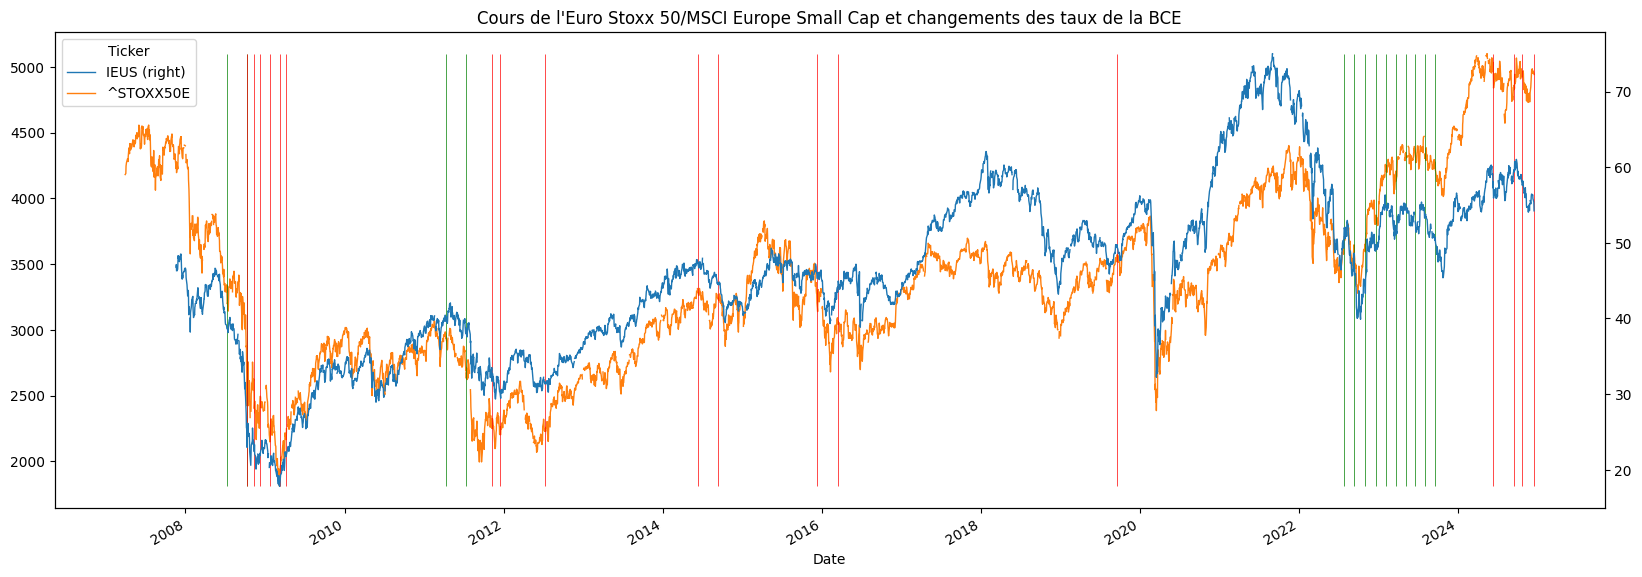

In [6]:
fig, ax = plt.subplots(figsize=(20,7))

max_es50 = euro_stoxx_50.max()
min_es50 = euro_stoxx_50.min()

min_date_es50 = euro_stoxx_50.index.min()
min_date_msciSC = msci_small.index.min()
min_date = max(min_date_es50, min_date_msciSC)

msci_es50.plot(ax = ax, sharex=True, secondary_y='IEUS', linewidth=1, title="Cours de l'Euro Stoxx 50/MSCI Europe Small Cap et changements des taux de la BCE")

ax.vlines(changes_pos.query('index >= @min_date').index, ymin=min_es50, ymax=max_es50, linewidth=0.5, color='g', label='Montée des taux')
ax.vlines(changes_neg.query('index >= @min_date').index, ymin=min_es50, ymax=max_es50, linewidth=0.5, color='r', label='Baisse des taux')


### Visuellement il semble être possible de générer de l'alpha si on connaît les cours en avance, puisque notre intuition semble correcte par rapport à la baisse/hausse des prix des actions européennes

## 2.2 BackTesting d'une stratégie simple (Long-Short) uniquement sur les jours de changements des taux

In [7]:
euro_stoxx_50['rt_es50'] = euro_stoxx_50['^STOXX50E'].pct_change()*100
msci_small['rt_msci_small'] = msci_small['IEUS'].pct_change()*100

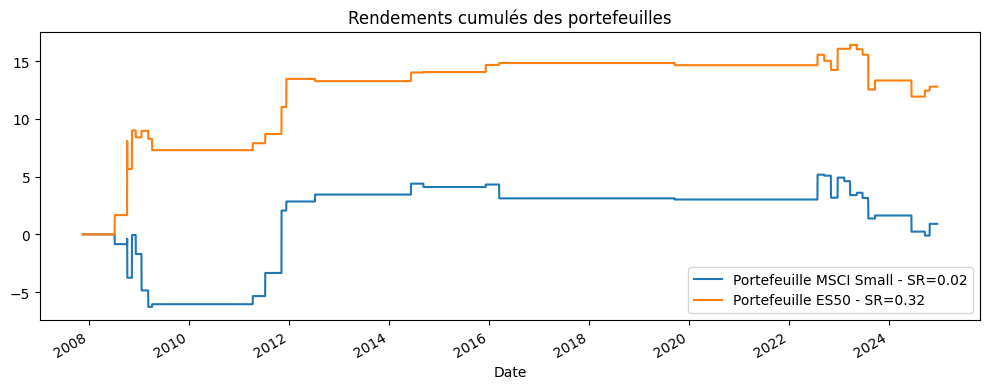

In [8]:
merge_msciSC_es50 = euro_stoxx_50.merge(msci_small, left_index=True, right_index=True)


merge_msciSC_es50 = merge_msciSC_es50.assign(
    signal = np.where(merge_msciSC_es50.index.isin(changes_pos.query('index >= @min_date').index), 1, 
    np.where(merge_msciSC_es50.index.isin(changes_neg.query('index >= @min_date').index), -1, 0))
)
                    

merge_msciSC_es50['pf_msciSC'] = merge_msciSC_es50['rt_msci_small']*merge_msciSC_es50.signal
merge_msciSC_es50['pf_es50'] = merge_msciSC_es50['rt_es50']*merge_msciSC_es50.signal

sharpe_pf_msciSC = np.sqrt(252)* (merge_msciSC_es50['pf_msciSC'].mean() / (merge_msciSC_es50['pf_msciSC'].std()))
sharpe_pf_es50 = np.sqrt(252)* (merge_msciSC_es50['pf_es50'].mean() / (merge_msciSC_es50['pf_es50'].std()))


fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Rendements cumulés des portefeuilles')

merge_msciSC_es50['pf_msciSC'].cumsum().plot(ax=ax, label=f'Portefeuille MSCI Small - SR={sharpe_pf_msciSC.round(2)}')
merge_msciSC_es50['pf_es50'].cumsum().plot(ax=ax, label=f'Portefeuille ES50 - SR={sharpe_pf_es50.round(2)}')

ax.legend()
fig.tight_layout()




# 2. Utilisation des articles de presse disponibles sur le site de l'ECB

In [10]:
ecb_press = pd.read_parquet('data/ecb_press.parquet')

In [11]:
#ecb_press.to_parquet('ecb_press.parquet', engine='fastparquet')

(array([   0,  500, 1000, 1500, 2000]),
 [Text(0, 0, '0'),
  Text(500, 0, '500'),
  Text(1000, 0, '1000'),
  Text(1500, 0, '1500'),
  Text(2000, 0, '2000')])

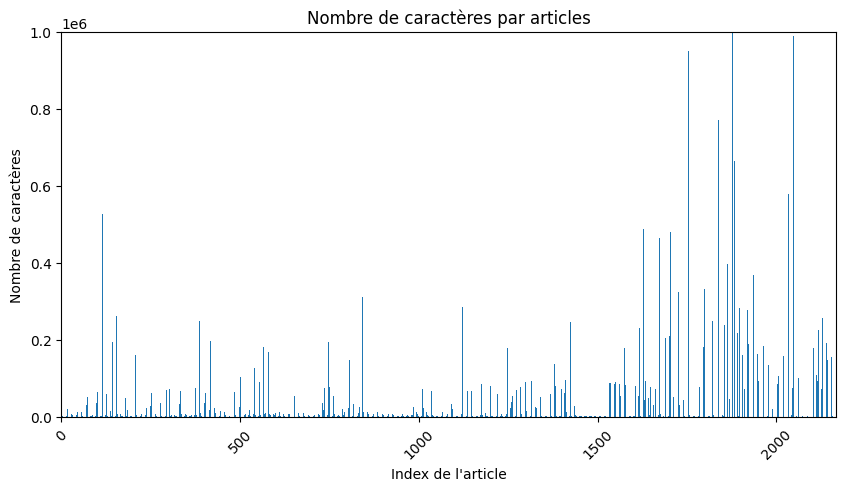

In [12]:
ecb_press['content'].str.len().plot(kind='bar',
                                    xticks=np.arange(0, ecb_press.shape[0],500),
                                    title="Nombre de caractères par articles",
                                    ylim=(0, 1e6), 
                                    figsize=(10,5),
                                    xlabel="Index de l'article", ylabel='Nombre de caractères')

plt.xticks(rotation=45)

## Pour traiter efficacement nos articles avec du NLP:
 1) On retire les articles qui dépassent 400 000 caractères
 2) On retire tous les caractères inutiles \n, \t ...
 3) On unformise le corpus en enlevant les majuscules

In [13]:
ecb_press_filtered = ecb_press.loc[ecb_press.content.str.len()<= 5e5].reset_index(drop=True).copy()
print("Nombre d'articles retirés après premier filtre :", ecb_press.shape[0] - ecb_press_filtered.shape[0])

Nombre d'articles retirés après premier filtre : 58


In [14]:
def nettoyer_texte(texte):
    if pd.isnull(texte):
        return texte
    texte = re.sub(r'[\n\t\r]+', ' ', texte)
    texte = re.sub(r'\s{2,}', ' ', texte)
    texte = re.sub(r'[^\w\s.,;:!?\'"-]', '', texte)
    texte = texte.strip()
    texte = texte.lower()
    return texte

print('Nombre de caractères totaux avant nettoyage :', ecb_press_filtered.content.str.len().sum())
ecb_press_filtered['content'] = ecb_press_filtered['content'].apply(lambda x: nettoyer_texte(x))
print('Nombre de caractères totaux après nettoyage :', ecb_press_filtered.content.str.len().sum())

Nombre de caractères totaux avant nettoyage : 69486160
Nombre de caractères totaux après nettoyage : 68482909


In [15]:
prompt = """You will analyze the given article text, sourced from the European Central Bank's (ECB) website. The goal is to extract structured data reflecting its relevance to European financial markets and to assess both the overall European market sentiment and sector-specific sentiment. The results must be output in a strict JSON format with the following fields:

1. Overall European market sentiment of the article:
   - global_sentiment:
     - score: A value between 0 and 1, where 0 = very negative, 0.5 = neutral, and 1 = very positive.
     - category: A string that can be "Negative", "Neutral", or "Positive" based on the score.

2. Overall market relevance (European context):
   - market_relevance_score: A value between 0 and 1 indicating how relevant the article is to European financial markets, where 0 = no relevance and 1 = very high relevance.

3. Sector analysis (European market sectors):
   Provide a list or array of objects, each representing one of the following European market sectors: "Banks", "Oil & Gas", "Technology", "Healthcare", and "Utilities". For each sector:
     - name: The sector name.
     - sentiment_score: A value between 0 and 1 indicating the sentiment towards that sector.
     - relevance_score: Must be one of the following values only: 0, 0.5, or 1, indicating the sector's relevance in the European context.

4. Key points and keywords:
   - key_points: A list of bullet-pointed key messages, facts, or insights from the article that could influence European financial markets.
   - keywords: A list of major themes or terms extracted from the article.

Instructions:
- Read the article text provided after these instructions.
- Analyze it according to the criteria above.
- Return the results strictly as a JSON object with the fields described, and no additional commentary outside of that JSON.

Use exactly this template format:
{
    "overall_european_market_sentiment": {
        "global_sentiment": {
            "score": 0.7,
            "category": "Positive"
        }
    },
    "overall_market_relevance": {
        "market_relevance_score": 1
    },
    "sector_analysis": [
        {
            "name": "Banks",
            "sentiment_score": 0.6,
            "relevance_score": 1
        },
        {
            "name": "Oil & Gas",
            "sentiment_score": 0,
            "relevance_score": 0
        },
        {
            "name": "Technology",
            "sentiment_score": 0.8,
            "relevance_score": 1
        },
        {
            "name": "Healthcare",
            "sentiment_score": 0,
            "relevance_score": 0
        },
        {
            "name": "Utilities",
            "sentiment_score": 0,
            "relevance_score": 0
        }
    ],
    "key_points": [
        "Point 1",
        "Point 2",
        "Point 3",
        "Point 4",
        "Point 5"
    ],
    "keywords": [
        "keyword1",
        "keyword2",
        "keyword3",
        "keyword4",
        "keyword5"
    ]
}"""

In [16]:
from pandas import json_normalize
import json
from tqdm import trange, tqdm

client = OpenAI()



def texte_analyse_gpt4(prompt, texte, temperature):
    
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            
            {
            "role": "system",
            "content": prompt
            },
            
            {
            "role": "user",
            "content": texte
            }
        ],
        temperature=temperature
    )
    
    return completion.choices[0].message.content

def nettoyer_json(chaine):
    
    chaine = chaine.strip()
    if chaine.startswith('```json'):
        chaine = chaine[len('```json'):].lstrip('\n')
    if chaine.endswith('```'):
        chaine = chaine[:-len('```')].rstrip()
        
    return chaine

def dataframe_json(json_data):
    try:

        data = json.loads(json_data)
        
        flattened_data = {}
        
        flattened_data['global_sentiment_score'] = data['overall_european_market_sentiment']['global_sentiment']['score']
        flattened_data['global_sentiment_category'] = data['overall_european_market_sentiment']['global_sentiment']['category']
        flattened_data['market_relevance_score'] = data['overall_market_relevance']['market_relevance_score']
        
        sectors = {sector['name']: sector for sector in data['sector_analysis']}
        for sector_name in ["Banks", "Oil & Gas", "Technology", "Healthcare", "Utilities"]:
            sector = sectors.get(sector_name, {})
            flattened_data[f'{sector_name}_sentiment_score'] = sector.get('sentiment_score', 0)
            flattened_data[f'{sector_name}_relevance_score'] = sector.get('relevance_score', 0)
        
        flattened_data['key_points'] = ' | '.join(data['key_points'])
        flattened_data['keywords'] = ' | '.join(data['keywords'])
        
        return pd.DataFrame([flattened_data])
    
    except json.JSONDecodeError as e:
        print(f"Erreur lors du parsing du JSON : {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Erreur inattendue : {e}")
        return pd.DataFrame()


def recolter_sentiment(prompt, temperature, ecb_press_df):
    
    df = pd.DataFrame()
            
    for i in trange(ecb_press_df.shape[0]):
        
        texte = ecb_press_df['content'].iloc[i]
        output = texte_analyse_gpt4(prompt=prompt, texte=texte, temperature=0)
        output = nettoyer_json(output)
        df_json = dataframe_json(output)
        
        df =pd.concat([df, df_json], axis=0)
        df.to_csv(f'ecb_sentiment_article.csv')
        
    df = df.reset_index(drop=True)   
    df_final = pd.concat([ecb_press_df, df], axis=1)
    
    return df_final
    
    

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [567]:
ecb_sentiment_ = pd.read_csv('ecb_sentiment_article.csv', index_col=0).reset_index(drop=True)

In [586]:
ecb_sentiment_
glob = pd.concat([ecb_press_filtered, ecb_sentiment_], axis=1)

In [587]:
glob = glob.set_index('date')

<Axes: xlabel='date'>

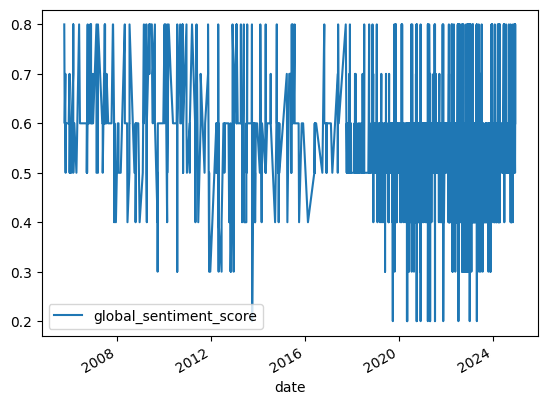

In [592]:

glob.plot(y= 'global_sentiment_score')

In [593]:
glob

,language,url,content,title_2,global_sentiment_score,global_sentiment_category,market_relevance_score,Banks_sentiment_score,Banks_relevance_score,Oil & Gas_sentiment_score,Oil & Gas_relevance_score,Technology_sentiment_score,Technology_relevance_score,Healthcare_sentiment_score,Healthcare_relevance_score,Utilities_sentiment_score,Utilities_relevance_score,key_points,keywords
date,,,,,,,,,,,,,,,,,,,
2024-12-12,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,feedback on fit in the ecosystem consultation ...,PDF Title,0.6,Positive,1.0,0.5,1.0,0.0,0.0,0.7,1.0,0.0,0.0,0.0,0.0,Digital euro will increase competition in the ...,digital euro | payment sector | competition | ...
2024-12-12,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,ecb-public preliminary methodology for calibra...,PDF Title,0.6,Positive,1.0,0.7,1.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,ECB is developing a methodology for setting di...,digital euro | holding limits | monetary polic...
2024-12-12,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,working document - preliminary for feedback on...,PDF Title,0.6,Positive,1.0,0.7,1.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,ECB is developing a methodology for setting di...,digital euro | holding limits | monetary polic...
2024-12-12,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,innovation partnerships nico schmidt 10122024 ...,PDF Title,0.8,Positive,1.0,0.7,1.0,0.0,0.0,0.9,1.0,0.0,0.0,0.0,0.0,Engagement with market participants on digital...,innovation partnerships | digital euro | marke...
2024-12-12,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,erpb technical sessions in 2025 10 december 20...,PDF Title,0.6,Positive,1.0,0.7,1.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,Five technical sessions scheduled for the digi...,digital euro | ERPB | technical sessions | fin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998-09-16,en,https://www.ecb.europa.eu/press/pr/date/1998/h...,the european central bank ecb will today publi...,The single monetary policy in Stage Three: Gen...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-08-31,en,https://www.ecb.europa.eu/pub/pdf/other/emoney...,report on electronic money august 1998 europea...,The single monetary policy in Stage Three: Gen...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-08-15,en,https://www.ecb.europa.eu/press/pr/date/1998/h...,today the european central bank ecb published ...,Report on electronic money,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [555]:
ecb_sentiment = recolter_sentiment(prompt=prompt, temperature=0, ecb_press_df=ecb_press_filtered)

 91%|█████████ | 1910/2110 [3:37:09<22:44,  6.82s/it]  


BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 128000 tokens. However, your messages resulted in 138361 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

In [558]:
ecb_press_filtered.content.str.len().sort_values(ascending=False).head(30)

1623    485205
1686    484351
1646    477808
1698    471737
1691    467952
1563    465871
1614    464385
1668    461937
1591    460880
1653    459294
1942    439022
1715    425584
1984    400906
1841    392904
1960    391642
1910    388840
1755    385822
1811    384101
1751    380912
2042    354258
1915    346037
1678    339648
1997    338028
1785    329272
1972    326808
1978    326369
1758    325849
1717    323786
1906    312965
777     309033
Name: content, dtype: int64

In [563]:
len(ecb_press_filtered.iloc[1910].content)

388840

In [550]:
ecb_sentiment

,language,url,date,content,title_2,global_sentiment_score,global_sentiment_category,market_relevance_score,Banks_sentiment_score,Banks_relevance_score,Oil & Gas_sentiment_score,Oil & Gas_relevance_score,Technology_sentiment_score,Technology_relevance_score,Healthcare_sentiment_score,Healthcare_relevance_score,Utilities_sentiment_score,Utilities_relevance_score,key_points,keywords
0,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,2024-12-12,feedback on fit in the ecosystem consultation ...,PDF Title,0.6,Positive,1,0.5,1,0,0,0.7,1.0,0,0,0,0,Digital euro will increase competition in the ...,digital euro | payment sector | intermediaries...
1,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,2024-12-12,ecb-public preliminary methodology for calibra...,PDF Title,0.6,Positive,1,0.7,1,0,0,0.5,0.5,0,0,0,0,ECB is developing a methodology for setting di...,digital euro | holding limits | monetary polic...


In [502]:
a = pd.DataFrame(data=[1, 2
                   ])

In [506]:
pd.concat([a, ecb_press_filtered.iloc[:2, :]], axis=1, ignore_index=True)

,0,1,2,3,4,5
0,1,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,2024-12-12,feedback on fit in the ecosystem consultation ...,PDF Title
1,2,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,2024-12-12,ecb-public preliminary methodology for calibra...,PDF Title


In [ ]:
# Définir les tickers par secteur
secteurs = {
    "Banks": "EXH1.DE",        # iShares STOXX Europe 600 Banks
    "Oil & Gas": "EXH2.DE",    # iShares STOXX Europe 600 Oil & Gas
    "Technology": "EXH4.DE",   # iShares STOXX Europe 600 Technology
    "Healthcare": "EXH3.DE",   # iShares STOXX Europe 600 Health Care
    "Utilities": "EXH5.DE"     # iShares STOXX Europe 600 Utilities
}

# Définir la période et l'intervalle pour les données
periode = "1y"      # 1 an
intervalle = "1d"   # Quotidien

# Télécharger les données pour chaque secteur
data_secteurs = {}
for secteur, ticker in secteurs.items():
    print(f"Téléchargement des données pour le secteur : {secteur} ({ticker})")
    indice = yf.Ticker(ticker)
    data = indice.history(period=periode, interval=intervalle)
    data['Secteur'] = secteur
    data_secteurs[secteur] = data

print("\nTéléchargement terminé.")

In [ ]:
ecb_press = pd.read_parquet('ecb_press.parquet')
ecb_press_filtered = ecb_press.loc[ecb_press.content.str.len()<= 5e5].reset_index(drop=True).copy()

df = pd.read_csv('ecb_sentiment_article.csv')
# df c le df que je t'envoie il faut reset l'index
df = df.reset_index(drop=True)   
# tu recupere le nb de ligne que j'ai jusqua mtn :
n = df.shape[0]
df_final = pd.concat([ecb_press_filtered.iloc[:n,:], df], axis=1)


print("Nombre d'articles retirés après premier filtre :", ecb_press.shape[0] - ecb_press_filtered.shape[0])